In [1]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import random
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')
from colossus.halo import concentration, mass_defs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from pylab import rcParams
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'
rcParams['font.family'] = 'serif'
rc('text.latex',preamble=r'\usepackage{/Volumes/Extreme_SSD/codes/master_thesis/code/configs/apjfonts}')
sz_ft = 18
sz_lb = 18
color_arr = ['firebrick', 'deepskyblue', 'seagreen']
from tqdm import tqdm
import cosmo
import lensing_estimator
from cosmo import CosmoCalc
import lensing
import foregrounds as fg
import experiments as exp
import sims
import stats
import tools

In [2]:
nber_clus = 3000
nber_rand = 50000
nber_cov = 1000
nber_runs = 25
map_params = [180, 0.5, 180, 0.5]
beamval = 1.0
noiseval = 2.0
l, cl = CosmoCalc().cmb_power_spectrum()
l, bl = exp.beam_power_spectrum(beam_fwhm = beamval)
l, nl = exp.white_noise_power_spectrum(noiseval_white = noiseval)
l, cl_noise =exp.white_noise_power_spectrum(noiseval_white = noiseval, beam_fwhm = beamval)
z = 0.7
cluster = [2e14, cosmo.concentration_parameter(2e14, z, 0.674), z]
centroid_shift_value = 0.5
mass_int = np.arange(0, 4, 0.1)

/Volumes/Extreme_SSD/codes/master_thesis/code/cosmo.py:98: RuntimeWarning: invalid value encountered in true_divide
  cl = dl * 2 * np.pi / (l*(l+1))


In [3]:
%%script false --no-raise-error
maps_rand = sims.cmb_mock_data(map_params, l, cl,  bl = bl, nl = nl, nber_obs = nber_rand)
stack_bg = lensing_estimator.stack(map_params, maps_rand, l = l, cl = cl, cl_noise = cl_noise)
del maps_rand
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_2uK-arcmin.npy', stack_bg)   

In [4]:
%%script false --no-raise-error
covariance_matrix, _ = lensing_estimator.covariance_and_correlation_matrix(nber_cov, nber_clus, map_params, l, cl, bl = bl, nl = nl, cl_noise = cl_noise)
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_2uK-arcmin.npy', covariance_matrix) 

In [5]:
%%script false --no-raise-error
model_profiles = lensing_estimator.model_profiles(nber_clus, map_params, l, cl, mass_int, z, centroid_shift_value = centroid_shift_value, bl = bl, cl_noise = cl_noise)
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_centroid_shift.npy', model_profiles)    

In [6]:
%%script false --no-raise-error
stack_bg = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_2uK-arcmin.npy')   
covariance_matrix = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_2uK-arcmin.npy')  
model_profiles_baseline =  np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_2uK-arcmin.npy')    
model_profiles_centroid_shift = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_centroid_shift.npy')     

    
lk_arr_baseline, mass_arr_baseline, error_arr_baseline = [], [], []    
lk_arr_centroid_shift, mass_arr_centroid_shift, error_arr_centroid_shift = [], [], []
lk_arr_centroid_shift_corrected, mass_arr_centroid_shift_corrected, error_arr_centroid_shift_corrected = [], [], []   
for i in tqdm(range(nber_runs)):    
    maps_clus_baseline, maps_clus_centroid_shift = sims.cmb_test_data(map_params, l, cl, cluster = cluster, centroid_shift_value = centroid_shift_value, bl = bl, nl = nl, nber_obs = nber_clus, clus_positions = True)                                                                             
    stack_clus_baseline = lensing_estimator.stack(map_params, maps_clus_baseline, l = l, cl = cl, cl_noise = cl_noise)
    stack_clus_centroid_shift = lensing_estimator.stack(map_params, maps_clus_centroid_shift, l = l, cl = cl, cl_noise = cl_noise)
    
    bins_baseline, lensing_dipole_profile_baseline, stack_baseline = lensing_estimator.lensing_dipole(map_params, stack_clus_baseline, stack_bg)
    bins_centroid_shift, lensing_dipole_profile_centroid_shift, stack_centroid_shift = lensing_estimator.lensing_dipole(map_params, stack_clus_centroid_shift, stack_bg)
    
    
    data_baseline = bins_baseline, lensing_dipole_profile_baseline, covariance_matrix
    data_centroid_shift = bins_centroid_shift, lensing_dipole_profile_centroid_shift, covariance_matrix

    likelihood_baseline, mass_baseline, error_baseline = stats.run_ml(data_baseline, model_profiles_baseline, mass_int)
    mass_int_lk_baseline, lk_baseline = likelihood_baseline
    likelihood_centroid_shift, mass_centroid_shift, error_centroid_shift = stats.run_ml(data_centroid_shift, model_profiles_baseline, mass_int)
    mass_int_lk_centroid_shift, lk_centroid_shift = likelihood_centroid_shift
    likelihood_centroid_shift_corrected, mass_centroid_shift_corrected, error_centroid_shift_corrected = stats.run_ml(data_centroid_shift, model_profiles_centroid_shift, mass_int)
    mass_int_lk_centroid_shift_corrected, lk_centroid_shift_corrected = likelihood_centroid_shift_corrected
    
    lk_arr_baseline.append(lk_baseline)
    lk_arr_centroid_shift.append(lk_centroid_shift)
    lk_arr_centroid_shift_corrected.append(lk_centroid_shift_corrected)
    mass_arr_baseline.append(mass_baseline)
    mass_arr_centroid_shift.append(mass_centroid_shift)
    mass_arr_centroid_shift_corrected.append(mass_centroid_shift_corrected)
    error_arr_baseline.append(error_baseline)
    error_arr_centroid_shift.append(error_centroid_shift)
    error_arr_centroid_shift_corrected.append(error_centroid_shift_corrected)
         
    del maps_clus_baseline
    del maps_clus_centroid_shift



mass_arr = [mass_arr_baseline, mass_arr_centroid_shift, mass_arr_centroid_shift_corrected]
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_arr_cluster_positions.npy', mass_arr)
error_arr = [error_arr_baseline, error_arr_centroid_shift, error_arr_centroid_shift_corrected]
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/error_arr_cluster_positions.npy', error_arr)

    
comb_lk_baseline, mass_comb_lk_baseline, error_comb_lk_baseline = stats.combined_likelihood(mass_int_lk_baseline, lk_arr_baseline)      
comb_lk_centroid_shift, mass_comb_lk_centroid_shift, error_comb_lk_centroid_shift = stats.combined_likelihood(mass_int_lk_centroid_shift, lk_arr_centroid_shift)      
comb_lk_centroid_shift_corrected, mass_comb_lk_centroid_shift_corrected, error_comb_lk_centroid_shift_corrected = stats.combined_likelihood(mass_int_lk_centroid_shift_corrected, lk_arr_centroid_shift_corrected)      
mass_arr_comb_lk = [mass_comb_lk_baseline, mass_comb_lk_centroid_shift, mass_comb_lk_centroid_shift_corrected]
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_arr_comb_lk_cluster_positions.npy', mass_arr_comb_lk)
error_arr_comb_lk = [error_comb_lk_baseline, error_comb_lk_centroid_shift, error_comb_lk_centroid_shift_corrected]
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/error_arr_comb_lk_cluster_positions.npy', error_arr_comb_lk) 


bias = (mass_comb_lk_centroid_shift-2)/2
inc_err_frac_centroid_shift = error_comb_lk_centroid_shift/error_comb_lk_baseline
inc_err_frac_centroid_shift_corrected = error_comb_lk_centroid_shift_corrected/error_comb_lk_baseline
result = "{0:11.3f}".format(bias)+'\n'
result+= "{0:11.3f}".format(inc_err_frac_centroid_shift)+'\n'
result+= "{0:11.3f}".format(inc_err_frac_centroid_shift_corrected)
file = open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/bias_result_cluster_positions.txt',"w")
file.write(result)
file.close() 

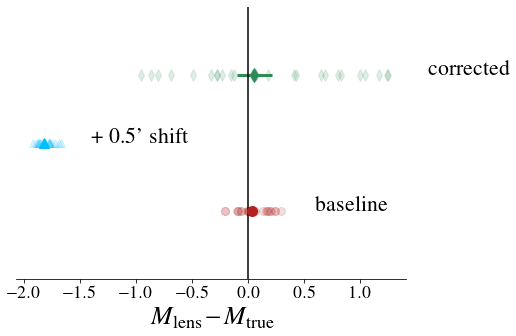

In [7]:
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_arr_cluster_positions.npy', 'rb') as file:
    mass_arr = np.load(file) 
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/error_arr_cluster_positions.npy', 'rb') as file:
    error_arr = np.load(file) 
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_arr_comb_lk_cluster_positions.npy', 'rb') as file:
    mass_arr_comb_lk = np.load(file) 
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/error_arr_comb_lk_cluster_positions.npy', 'rb') as file:
    error_arr_comb_lk = np.load(file) 

fig, ax = plt.subplots(figsize=(7,5))
centers_baseline = np.asarray(mass_arr[0])-2
centers_centroid_shift = np.asarray(mass_arr[1])-2
centers_centroid_shift_corrected = np.asarray(mass_arr[2])-2
centers = [centers_baseline, centers_centroid_shift, centers_centroid_shift_corrected]
width_arr = [error_arr[0], error_arr[1], error_arr[2]]
yvals = [0.25,0.5,0.75]
ax.set_ylim(0.,1.)
markers = ['o', '^', 'd']
for cntr, (center, widthval, colorval) in enumerate(zip(centers, width_arr, color_arr )):
    yval = [yvals[cntr] for i in range(len(center))]
    plt.plot(center, yval, color = colorval, marker = markers[cntr], markersize = sz_lb-10, ls = '', alpha = 0.15)
plt.errorbar(mass_arr_comb_lk[0]-2, yvals[0], xerr = error_arr_comb_lk[0],elinewidth=sz_lb-15, color = color_arr[0],  marker = 'o', markersize = sz_lb-8, ls = '')
plt.errorbar(mass_arr_comb_lk[1]-2, yvals[1], xerr = error_arr_comb_lk[1], elinewidth=sz_lb-15,color = color_arr[1], marker = '^', markersize = sz_lb-8, ls = '')
plt.errorbar(mass_arr_comb_lk[2]-2, yvals[2], xerr = error_arr_comb_lk[2],elinewidth=sz_lb-15, color = color_arr[2], marker = 'd', markersize = sz_lb-8, ls = '')
plt.axvline(0, color = 'black', ls = '-')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelsize = sz_lb)
ax.axes.yaxis.set_ticks([])
plt.text(0.6, yvals[0], 'baseline', fontsize = sz_lb+4)
plt.text(-1.4, yvals[1], '+ 0.5\' shift', fontsize = sz_lb+4)
plt.text(1.6, yvals[2], 'corrected', fontsize = sz_lb+4)
plt.xlabel(r'$M_{\rm lens}-M_{\rm true}$', fontsize = sz_ft+8)
plt.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/cluster_positions.pdf', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)